<a href="https://colab.research.google.com/github/leyixu21/master_thesis/blob/main/clean_flickr_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations

In [2]:
! pip install flickrapi
! pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 6.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 85.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
from flickrapi import FlickrAPI
import pandas as pd
from pandas.io.formats.format import NA
import numpy as np
import datetime
import re
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import pickle
import folium
import geopandas as gpd


In [5]:
# set paths
path='/content/drive/MyDrive/master_thesis_data/flickr/'
path_semi = '/content/drive/MyDrive/master_thesis_data/flickr/semi_cleaned/'

# Preprocess Flick Data

## Clean Data in Each Year

In [ ]:
# read data
output_geojson = 'london_flickr_'
y = 2013

gdf = gpd.read_file(path+output_geojson+str(y)+'.geojson')

# get column names
gdf.columns

In [ ]:
len(gdf)

447730

In [ ]:
# select necessary columns
gdf = gdf[['owner', 'accuracy', 'datetaken', 'datetakenunknown', 'tags', 'title', 'geometry']]

# convert string to datetime format
gdf['datetaken'] = pd.to_datetime(gdf['datetaken'], format='%Y-%m-%d %H:%M:%S')
# get date
gdf['date'] = gdf['datetaken'].apply(lambda x: x.date())
# sort by datetaken
gdf = gdf.sort_values(by='datetaken')

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# remove photos with no tags
gdf = gdf.dropna(subset=['tags'])

Remove photos with accuracy below 14

In [ ]:
# remove photos with accuracy lower than 14
gdf = gdf[gdf['accuracy']>=14]

In [ ]:
len(gdf)

358325

### Clean Tags

Remove non-English tags and tags with non-Ascii characters, special characters, numbers, and stop-word

In [ ]:
# define a function to detect non-Ascii characters
def containsNonAscii(s):
  return any(ord(i)>127 for i in s)

# define a function to detect special characters and numbers
def containsNonSpecialChar(s):
  return bool(re.match('^[a-zA-Z]*$',s))

# define a function to detect stop-words
def containsNonStopW(s):
  return s != 'a' and s != 'an' and s != 'the'

# define a function to detect general place names
def containsNonGeneralP(s):
  general_places = ['britain', 'united', 'kingdom', 'uk', 'england', 'london']   # London
  # general_places = ['switzerland', 'swiss', 'schweiz', 'suisse', 'zurich', 'zuerich', 'zueri', 'zurigo']   # Zurich
  return all(x not in s for x in general_places)

# define a function to detect irrelevant tags
def containsNonIrreT(s):
  irrelevant = ['nikon', 'iphoneography', 'flickr', 'instagram', 'samsung']
  return all(x not in s for x in irrelevant)

for i, row in gdf.iterrows():
  # split the tag string to the list
  words = row['tags'].split()
  cleaned_words = [word for word in words if not containsNonAscii(word)]
  cleaned_words = [word for word in cleaned_words if containsNonSpecialChar(word)]
  cleaned_words = [word for word in cleaned_words if containsNonStopW(word)]
  cleaned_words = [word for word in cleaned_words if containsNonGeneralP(word)]
  cleaned_words = [word for word in cleaned_words if containsNonIrreT(word)]
  # remove duplicates in the same tag list
  cleaned_words = list(set(cleaned_words))
  # convert the tag list back to the string
  cleaned_words = ' '.join(cleaned_words)
  gdf['tags'][i] = cleaned_words

# remove photos with no tags again
gdf = gdf.dropna(subset=['tags'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Clean Users

Remove duplicates

In [ ]:
# remove duplicates
gdf = gdf.drop_duplicates(subset=['owner', 'tags', 'datetaken'])

In [ ]:
# group data by users
gdf_gb_users = gdf.groupby('owner')

# get the list of users
users = list(gdf_gb_users.groups.keys())

Remove unprolific users

In [ ]:
# get users who took more than 5 photos in total at different places over a 24-h period
# iterate the users
for i in users:
  user = gdf_gb_users.get_group(i)
  # group data of the specific user by date
  user_gb_date = user.groupby('date', as_index=False)
  # count the number of photos this user took each day
  user_gb_date_count = user_gb_date.count()
  # get the list of dates when the photos were less than 5
  date_sparse = user_gb_date_count[user_gb_date_count['tags'] < 5].date.to_list()
  # remove users who uploaded sparse photos within a day
  gdf = gdf[(gdf['owner'] != i) | (~gdf['date'].isin(date_sparse))]


# group data by users again
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users
users = list(gdf_gb_users.groups.keys())

Remove prolific users who uploaded more than 5% photos of the dataset


In [ ]:
# count the number of photos each user uploaded
gdf_gb_users_count = pd.DataFrame(gdf_gb_users.count())
# calculate the percent of photos each user uploaded
gdf_gb_users_count['percent'] = (gdf_gb_users_count['tags'] / gdf_gb_users_count['tags'].sum()) * 100
gdf_gb_users_count = gdf_gb_users_count.sort_values('percent', ascending=False)

# get the id of users who uploaded too many photos
users_prolific = gdf_gb_users_count[gdf_gb_users_count['percent'] > 5].owner
# remove prolific users
gdf = gdf[~gdf['owner'].isin(users_prolific)]


Save the semi-cleaned data

In [ ]:
# save the semi-cleaned data as pkl
gdf.to_pickle(path_semi+output_geojson+'semi_'+str(y)+'.pkl')


In [ ]:
len(gdf)

270312

## Clean the Whole Data

In [6]:
# combine data in 2012 and 2013
gdf = []
for y in range(2012, 2014):
  gdf_y = pd.read_pickle(path_semi+'london_flickr_semi_'+str(y)+'.pkl')
  gdf.append(gdf_y)
gdf = pd.concat(gdf)


In [7]:
# select data from 2012-04-03 to 2013-09-16
start_date = pd.to_datetime('2012-04-03', format='%Y-%m-%d')
end_date = pd.to_datetime('2013-09-16', format='%Y-%m-%d')
gdf = gdf[(gdf['date']>=start_date)&(gdf['date']<=end_date)]

/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [8]:
# group data by users
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users
users = list(gdf_gb_users.groups.keys())


# get all tags
tags = list(gdf['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags = list(np.concatenate(tags).flat)

# count tags
tags_count = Counter(tags)

# get the list of unique tags
tags_unique = list(tags_count.keys())

### Remove Tags based on CV

Remove tags with the coefficient variation larger than 200 to reduce contribution bias


In [ ]:
# create a dictionary to store the usage frequency of tags over users
tags_freq = {}
for i in tags_unique:
  # create a list to store the tag usage frequency of each user
  tag_users = []
  for j in users:
    user = gdf_gb_users.get_group(j)
    # get the tags used by the user
    user_tags = list(user['tags'].apply(lambda x: x.split()))
    user_tags = list(np.concatenate(user_tags).flat)
    # get the frequency of the tag used by the user
    freq = user_tags.count(i)
    tag_users.append(freq)
  tags_freq[i] = tag_users

#convert the dictionary to the dataframe
tags_freq = pd.DataFrame(tags_freq)



In [ ]:
tags_freq.to_pickle(path+'tags_freq.pkl')
tags_freq


In [ ]:
# define function to calculate cv
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 

# get the coefficient of variation of tags based on the frequency
tags_cv = tags_freq.apply(cv)

# remove tags based on cv
# gdf = 

# remove photos with no tags again
gdf = gdf.dropna(subset=['tags'])

In [ ]:
tags_cv.sort_values()

In [ ]:
tags_freq['city'].plot()

In [ ]:
tags_freq['fruehling'].plot()

In [ ]:
tags_freq['svizzera'].plot()

In [ ]:
tags_cv.to_pickle(path+'tags_cv_2014.pkl')
# tags_cv = pd.read_pickle(path+'tags_cv_2012to2014.pkl')

In [ ]:
# group data by users again
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users
users = list(gdf_gb_users.groups.keys())


# get all tags
tags = list(gdf['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags = list(np.concatenate(tags).flat)

# count tags
tags_count = Counter(tags)

# get the list of unique tags
tags_unique = list(tags_count.keys())

tags_count.most_common()

In [ ]:
tags_count = pd.DataFrame.from_dict(tags_count, orient='index')[0]
tags_count.to_pickle(path+'tags_count_2014.pkl')

In [ ]:
# # save cleaned data as pkl
# gdf.to_pickle(path+output_geojson+'cleaned_'+str(y)+'.pkl')


Data from 2012.04 to 2013.09, corresponding to the time of Foursquare data

In [ ]:
semi2012 = pd.read_pickle(path_semi+'london_flickr_semi_2012.pkl')
semi2013 = pd.read_pickle(path_semi+'london_flickr_semi_2013.pkl')

In [ ]:
semi2012[semi2012['date']>=pd.to_datetime('2012-04-01', format='%Y-%m-%d')]

/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,owner,accuracy,datetaken,datetakenunknown,tags,title,geometry,date
101480,29824553@N00,16.0,2012-04-01 07:19:05,0.0,mulher londres olympics bicicleta nuvens verme...,Trafalgar Square - London - England,POINT (-0.12779 51.50855),2012-04-01
101485,29824553@N00,16.0,2012-04-01 07:29:34,0.0,mulher londres nationalgallery olympics bicicl...,The National Gallery - Trafalgar Square - Lond...,POINT (-0.12835 51.50860),2012-04-01
101487,29824553@N00,16.0,2012-04-01 07:35:44,0.0,mulher themall londres olympics bicicleta nuve...,"""The Mini and The Mall"" - London - England",POINT (-0.12923 51.50677),2012-04-01
101492,29824553@N00,16.0,2012-04-01 08:04:16,0.0,white mulher tempo themall londres olympics bi...,"""Black n.º 1"" - Big Ben - London - England",POINT (-0.12386 51.50080),2012-04-01
101494,29824553@N00,16.0,2012-04-01 08:06:37,0.0,white mulher tempo themall londres olympics bi...,"""It was a beautiful day"" - Big Ben - London - ...",POINT (-0.12386 51.50080),2012-04-01
...,...,...,...,...,...,...,...,...
506520,14721410@N03,16.0,2012-12-31 12:48:58,0.0,jonperry connectingwithnature enlightenshade a...,"_MG_7925R Connecting With Nature no1, Enlighte...",POINT (-0.29776 51.47562),2012-12-31
506522,87583925@N00,16.0,2012-12-31 12:49:39,0.0,eastlancs bigbustours volvo visionaire,London,POINT (-0.15824 51.51324),2012-12-31
506525,36101699310@N01,16.0,2012-12-31 12:55:52,0.0,paddington,Paddington station (H&C),POINT (-0.17848 51.51868),2012-12-31
506527,36101699310@N01,16.0,2012-12-31 12:56:59,0.0,paddington,Paddington station (H&C),POINT (-0.17898 51.51853),2012-12-31


In [ ]:
semi2013[semi2013['date']<=pd.to_datetime('2013-09-01', format='%Y-%m-%d')]

/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,owner,accuracy,datetaken,datetakenunknown,tags,title,geometry,date
350518,35109168@N00,16.0,2013-01-01 08:02:43,0.0,parade trips newyearsday,IMG_1642,POINT (-0.12724 51.50629),2013-01-01
350378,35109168@N00,16.0,2013-01-01 08:02:57,0.0,parade trips newyearsday,IMG_1647,POINT (-0.12724 51.50629),2013-01-01
350618,35109168@N00,16.0,2013-01-01 08:03:14,0.0,parade trips newyearsday,IMG_1653,POINT (-0.12724 51.50629),2013-01-01
350510,35109168@N00,16.0,2013-01-01 08:03:35,0.0,parade trips newyearsday,IMG_1655,POINT (-0.12724 51.50629),2013-01-01
350552,35109168@N00,16.0,2013-01-01 08:04:29,0.0,parade trips newyearsday,IMG_1657,POINT (-0.12724 51.50629),2013-01-01
...,...,...,...,...,...,...,...,...
105578,71312330@N00,16.0,2013-09-01 22:35:06,0.0,,NaN,POINT (-0.12590 51.49953),2013-09-01
361382,71312330@N00,16.0,2013-09-01 22:37:57,0.0,,NaN,POINT (-0.12666 51.50061),2013-09-01
348777,71312330@N00,16.0,2013-09-01 22:39:27,0.0,,NaN,POINT (-0.12781 51.50007),2013-09-01
100413,71312330@N00,16.0,2013-09-01 22:40:46,0.0,,NaN,POINT (-0.13000 51.49940),2013-09-01


In [ ]:
# merge two datasets
semi_2012_2013 = pd.concat([semi2012[semi2012['date']>=pd.to_datetime('2012-04-01', format='%Y-%m-%d')],
                            semi2013[semi2013['date']<=pd.to_datetime('2013-09-01', format='%Y-%m-%d')]])

semi_2012_2013

/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,owner,accuracy,datetaken,datetakenunknown,tags,title,geometry,date
101480,29824553@N00,16.0,2012-04-01 07:19:05,0.0,mulher londres olympics bicicleta nuvens verme...,Trafalgar Square - London - England,POINT (-0.12779 51.50855),2012-04-01
101485,29824553@N00,16.0,2012-04-01 07:29:34,0.0,mulher londres nationalgallery olympics bicicl...,The National Gallery - Trafalgar Square - Lond...,POINT (-0.12835 51.50860),2012-04-01
101487,29824553@N00,16.0,2012-04-01 07:35:44,0.0,mulher themall londres olympics bicicleta nuve...,"""The Mini and The Mall"" - London - England",POINT (-0.12923 51.50677),2012-04-01
101492,29824553@N00,16.0,2012-04-01 08:04:16,0.0,white mulher tempo themall londres olympics bi...,"""Black n.º 1"" - Big Ben - London - England",POINT (-0.12386 51.50080),2012-04-01
101494,29824553@N00,16.0,2012-04-01 08:06:37,0.0,white mulher tempo themall londres olympics bi...,"""It was a beautiful day"" - Big Ben - London - ...",POINT (-0.12386 51.50080),2012-04-01
...,...,...,...,...,...,...,...,...
105578,71312330@N00,16.0,2013-09-01 22:35:06,0.0,,NaN,POINT (-0.12590 51.49953),2013-09-01
361382,71312330@N00,16.0,2013-09-01 22:37:57,0.0,,NaN,POINT (-0.12666 51.50061),2013-09-01
348777,71312330@N00,16.0,2013-09-01 22:39:27,0.0,,NaN,POINT (-0.12781 51.50007),2013-09-01
100413,71312330@N00,16.0,2013-09-01 22:40:46,0.0,,NaN,POINT (-0.13000 51.49940),2013-09-01


In [ ]:
# get the number of users
print('The number of users is ' + str(semi_2012_2013['owner'].unique().size))

The number of users is 6030


In [ ]:
# get all tags
tags = list(semi_2012_2013['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags = list(np.concatenate(tags).flat)

In [ ]:
# remove tags containing samsung
for item in tags.copy():
    if 'samsung' in item:
        tags.remove(item)

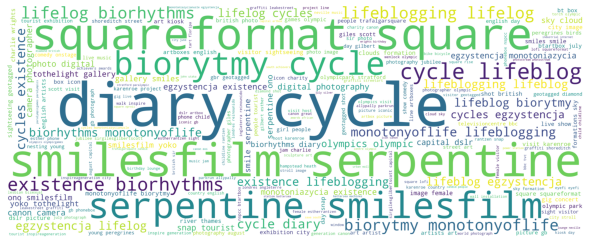

In [ ]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd


comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in tags:
  # split the value
  tokens = val.split()
  
  # Converts each token into lowercase
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
  
  comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 5000, height = 2000,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

# Extract Locals and Tourists

## Get Users Profiles and Time Interval

In [ ]:
# get the location and time interval of users to extract locals and tourists


# https://www.flickr.com/services/api/flickr.profile.getProfile.html
# https://www.flickr.com/services/api/flickr.people.getInfo.html


## Add your API Key and secret of Flickr
key = "0c15e34e5d1c5ed988c007ab2992ed25"
secret = "c43c334c97c11d2c"

# connecting to Flickr
flickr = FlickrAPI(key, secret, format='parsed-json')

# create a dictionary to store the users profile (hometown, city, country)
users_profile = {}
# create a dictionary to store the time interval between the first and last photos of users
users_interval = {}

# iterate users
for i in users:
  # get the profile
  result = flickr.profile.getProfile(user_id=i)

  # set locations as NaN in case some of them are missing
  hometown = np.nan
  city = np.nan
  country = np.nan

  # get locations from the profile if they exist
  if 'hometown' in result['profile'].keys():
    if result['profile']['hometown'] != '':
      hometown = result['profile']['hometown']
  if 'city' in result['profile'].keys():
    if result['profile']['city'] != '':
      city = result['profile']['city']
  if 'country' in result['profile'].keys():
    if result['profile']['country'] != '':
      country = result['profile']['country']
  
  # add the list of locations to the profile of this user
  users_profile[i] = [hometown, city, country]
  

  # get the user data
  user = gdf_gb_users.get_group(i)
  user = user.sort_values('date')
  # get the time interval (days)
  interval = (user['date'].iloc[-1] - user['date'].iloc[-0]).days + 1
  users_interval[i] = [interval]


#convert the dictionary to the dataframe
users_profile = pd.DataFrame(users_profile).transpose()
users_interval = pd.DataFrame(users_interval).transpose()
# convert the index to the column
users_profile = users_profile.reset_index()
users_interval = users_interval.reset_index()
# rename the columns
users_profile.columns = ['owner', 'hometown', 'city', 'country']
users_interval.columns = ['owner', 'interval']

# join two dataframes
users_info = users_profile.join(users_interval.set_index('owner'), on='owner')
users_info.to_pickle(path+'users_info_'+str(y)+'.pkl')

In [ ]:
users_info = pd.read_pickle(path+'users_info_'+str(y)+'.pkl')
users_info

,owner,hometown,city,country,interval
0,100251406@N07,Alger,NaN,NaN,4
1,100350464@N04,Strasbourg,NaN,NaN,3
2,100872466@N04,NaN,NaN,NaN,1
3,100940682@N04,NaN,NaN,NaN,1
4,100978997@N07,Hämeenlinna,Iisalmi,Finland,3
...,...,...,...,...,...
1078,9937468@N08,NaN,NaN,NaN,1
1079,99656237@N00,NaN,NaN,NaN,1
1080,99713555@N00,NaN,Moerfelden-Walldorf,Germany,1
1081,99809597@N00,NaN,NaN,NaN,1


### Explore the Locations of Users

In [ ]:
users_info['hometown'].unique()

array(['Alger', 'Strasbourg', nan, 'Hämeenlinna', 'London', 'Mexico City',
       'Valencia (Spain)', 'New York', 'Oswestry', 'Paisley', 'Norwich',
       'Rio de Janeiro', 'NORWICH', 'Dublin, Ireland', 'York',
       'Gerrards Cross', 'Raised in Aberdeenshire', 'The Hague',
       'Redditch', 'Leeds', 'Liverpool,', 'Nijmegen, Netherlands',
       'Arras', 'Argaka, Cyprus', 'Banstead', 'Wokingham',
       'Blaenau Ffestiniog', 'Long Island, N.Y.', 'Hertfordshire',
       'Plymouth', 'Cremona', 'Colleferro (Rome)', 'Wesseling',
       'Zhukovsky', 'Chascomús', 'Moscow', 'Perth', 'Augsburg',
       'Workington', 'Athens,Greece', 'Portsmouth',
       'Dagenham. London Borough of Barking &amp; Dagenham. Or (postally) Essex if you prefer, which I do.',
       'Alexandria', 'Lima', 'Manchester', 'Byfleet',
       'Fermoy, Co. Cork. Ireland', 'South London', "Bishop's Stortford",
       'Hamburg', 'The mighty RGT, Rugeley', 'Pitt Meadows, BC, Canada',
       'Dublin', 'Ilkeston ', 'Columbus',

In [ ]:
users_info['city'].unique()

array([nan, 'Iisalmi', 'London', 'Vancouver', 'Musselburgh', 'Hamburg',
       'London Town', 'Glasgow', 'Vancouver, BC', 'Fullerton CA',
       'Wimbledon', 'Lyndhurst, New Forest', ' SOUTH BUCKS.', 'Dublin',
       'York', 'Coventry', 'Liverpool', 'Nijmegen', 'Paris',
       'Swadlincote', 'Teddington', 'Southampton', 'Blaenau Ffestiniog',
       'Sunbury on Thames', 'Oslo', 'Grantham, Lincolnshire', 'Cape Town',
       'Bedfordshire, England', 'Roma', 'Paris/Caen', 'Bristol',
       'Mar del Plata', 'Frigate Bay', 'Perth', 'Augsburg', 'Woking',
       'Krefeld', 'Athens', 'Southsea', 'Dagenham', 'Alexandria', 'Lima',
       'Somerset', 'Milton Keynes', 'Inverness', 'Byfleet', 'Harlow',
       'Schenefeld', 'Always lived in Rugeley', 'Ilkeston ',
       'Gillingham (Kent)', 'Columbus', 'Rotterdam', 'Leatherhead',
       'Croydon', None, 'Whittlesey ', 'Abu Dhabi', 'Middle River',
       'Essex', 'Doncaster', 'Portsmouth', 'Preston', 'Minneapolis',
       'Milano', 'Klein, Texas', 'Re

In [ ]:
users_info['country'].unique()

array([nan, 'Finland', 'England', 'Canada', 'Scotland', 'UK',
       'United States', 'Deutschland', 'United Kingdom', 'Spain', 'USA',
       'ENGLAND U.K.', 'Ireland', 'The Netherlands', 'U.K.', 'Holland',
       'France', None, 'Cymru / Wales', 'Norway', 'South Africa', 'Italy',
       'Argentina', 'St Kitts & Nevis', 'Western Australia', 'Germany',
       'Greece', 'Peru', 'It better be in England or we are in trouble',
       'England ', 'Netherlands', 'UAE', 'England, United Kingdom',
       ' United Kingdom', 'Britain', 'Italia', 'Austria',
       'Northern Ireland', 'Netherlands/ Poland', 'Philippines', 'Wales',
       'Australia', 'Kuwait', 'Blighty', 'Japan', 'United Kingdom.',
       'FRANCE', 'Hungary', 'US', 'usa', 'Berkshire', 'New Zealand',
       'Russia', 'Latvia', '香港', 'Rule Brittania !', 'Italia / UK',
       'Brasil', 'U.K. ', 'uk', 'Cambridgeshire', 'South Wales',
       'England United Kingdom', 'Great Britain', 'Trinidad', 'Singapore',
       'Belgium', 'Europe',

### Determine the Threshold for Time Interval

In [ ]:
locals_candi = users_info[(users_info['hometown'].str.contains('London')==True) | (users_info['city'].str.contains('London')==True)]
locals_candi

,owner,hometown,city,country,interval
5,10103515@N07,London,London,England,56
11,10332960@N03,London,Musselburgh,Scotland,273
12,103429480@N03,Valencia (Spain),London,UK,1
15,10396813@N04,Oswestry,London Town,United Kingdom,246
31,10865013@N05,London,London,England,97
...,...,...,...,...,...
1057,96735117@N03,London,NaN,NaN,203
1063,97938415@N00,Norwich,London,UK,245
1068,98587546@N00,Manchester,London,England,283
1075,99145208@N00,NaN,London,UK,3


In [ ]:
locals_candi['interval'].describe()

count    181.00000
mean     136.61326
std      127.97072
min        1.00000
25%        1.00000
50%      112.00000
75%      253.00000
max      364.00000
Name: interval, dtype: float64

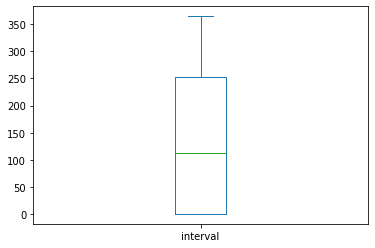

In [ ]:
locals_candi['interval'].plot.box()

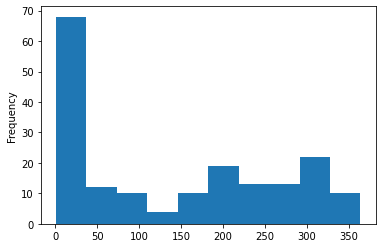

In [ ]:
locals_candi['interval'].plot.hist()

In [ ]:
len(users_info)

1083

In [ ]:
tourists_candi = users_info.loc[users_info.index.difference(locals_candi.index)]
tourists_candi

,owner,hometown,city,country,interval
0,100251406@N07,Alger,NaN,NaN,4
1,100350464@N04,Strasbourg,NaN,NaN,3
2,100872466@N04,NaN,NaN,NaN,1
3,100940682@N04,NaN,NaN,NaN,1
4,100978997@N07,Hämeenlinna,Iisalmi,Finland,3
...,...,...,...,...,...
1078,9937468@N08,NaN,NaN,NaN,1
1079,99656237@N00,NaN,NaN,NaN,1
1080,99713555@N00,NaN,Moerfelden-Walldorf,Germany,1
1081,99809597@N00,NaN,NaN,NaN,1


In [ ]:
tourists_candi['interval'].describe()

count    902.000000
mean      59.248337
std      103.245246
min        1.000000
25%        1.000000
50%        2.000000
75%       61.750000
max      362.000000
Name: interval, dtype: float64

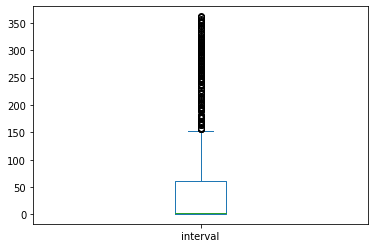

In [ ]:
tourists_candi['interval'].plot.box()

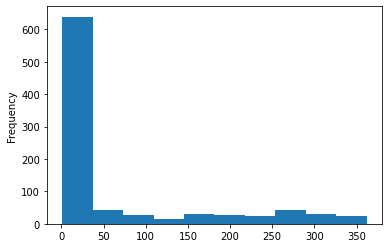

In [ ]:
tourists_candi['interval'].plot.hist()

In [ ]:
tourists_candi[tourists_candi['interval'] < 30]

,owner,hometown,city,country,interval
0,100251406@N07,Alger,NaN,NaN,4
1,100350464@N04,Strasbourg,NaN,NaN,3
2,100872466@N04,NaN,NaN,NaN,1
3,100940682@N04,NaN,NaN,NaN,1
4,100978997@N07,Hämeenlinna,Iisalmi,Finland,3
...,...,...,...,...,...
1078,9937468@N08,NaN,NaN,NaN,1
1079,99656237@N00,NaN,NaN,NaN,1
1080,99713555@N00,NaN,Moerfelden-Walldorf,Germany,1
1081,99809597@N00,NaN,NaN,NaN,1


## Extract Two Groups of Users

In [ ]:
# add the column tourist to indicate whether the user is a tourist or a local (y means tourist, n means local)
# assume all users are tourists first
users_info['tourist'] = 'y'

# label the users whose hometown or city is London as locals
locals_candi = users_info[(users_info['hometown'].str.contains('London')==True) | (users_info['city'].str.contains('London')==True)]
users_info.at[locals_candi.index, 'tourist'] = 'n'

# iterate users to find locals based on the interval
for idx, row in users_info.iterrows():
  if row['interval'] > 30:
    users_info.at[idx, 'tourist'] = 'n'

In [ ]:
users_info[users_info['tourist']=='n']


,owner,hometown,city,country,interval,tourist
5,10103515@N07,London,London,England,56,n
11,10332960@N03,London,Musselburgh,Scotland,273,n
12,103429480@N03,Valencia (Spain),London,UK,1,n
14,103921337@N03,NaN,Hamburg,Deutschland,274,n
15,10396813@N04,Oswestry,London Town,United Kingdom,246,n
...,...,...,...,...,...,...
1066,98406434@N00,NaN,NaN,UK,101,n
1068,98587546@N00,Manchester,London,England,283,n
1071,98942020@N00,NaN,NaN,NaN,53,n
1075,99145208@N00,NaN,London,UK,3,n


In [ ]:
users_info[users_info['tourist']=='y']

,owner,hometown,city,country,interval,tourist
0,100251406@N07,Alger,NaN,NaN,4,y
1,100350464@N04,Strasbourg,NaN,NaN,3,y
2,100872466@N04,NaN,NaN,NaN,1,y
3,100940682@N04,NaN,NaN,NaN,1,y
4,100978997@N07,Hämeenlinna,Iisalmi,Finland,3,y
...,...,...,...,...,...,...
1078,9937468@N08,NaN,NaN,NaN,1,y
1079,99656237@N00,NaN,NaN,NaN,1,y
1080,99713555@N00,NaN,Moerfelden-Walldorf,Germany,1,y
1081,99809597@N00,NaN,NaN,NaN,1,y


In [ ]:
# join the users information to gdf
gdf = gdf.join(users_info[['owner', 'tourist']].set_index('owner'), on='owner')
gdf

,owner,accuracy,datetaken,datetakenunknown,tags,title,geometry,date,tourist
13,79691705@N05,16.0,2019-01-01 09:22:41,0.0,lhr egll canon planespotting airplane oneworld...,American Airlines | Boeing 777-300ER | N730AN ...,POINT (-0.43950 51.45992),2019-01-01,n
15,58563435@N02,16.0,2019-01-01 09:28:12,0.0,lnydp piccadilly,London New Years Day Parade 2019-1,POINT (-0.13622 51.50926),2019-01-01,n
18,79691705@N05,16.0,2019-01-01 09:37:47,0.0,lhr egll canon planespotting airplane ein eied...,Aer Lingus | Airbus A320-200 | EI-EDS | London...,POINT (-0.43950 51.45992),2019-01-01,n
20,79691705@N05,16.0,2019-01-01 09:39:54,0.0,singapore lhr egll canon planespotting airplan...,Singapore Airlines | Boeing 777-300ER | 9V-SWS...,POINT (-0.43950 51.45992),2019-01-01,n
21,79691705@N05,16.0,2019-01-01 09:42:53,0.0,ba gzbjf lhr egll canon planespotting airplane...,British Airways | Boeing 787-8 | G-ZBJF | Lond...,POINT (-0.43950 51.45992),2019-01-01,n
...,...,...,...,...,...,...,...,...,...
205310,21204781@N07,16.0,2019-12-31 12:16:21,0.0,,V&A_379_e,POINT (-0.17308 51.49672),2019-12-31,y
205311,21204781@N07,16.0,2019-12-31 12:17:07,0.0,,V&A_378_e,POINT (-0.17308 51.49672),2019-12-31,y
205313,21204781@N07,16.0,2019-12-31 12:17:59,0.0,,V&A_377_e,POINT (-0.17308 51.49672),2019-12-31,y
205320,21204781@N07,16.0,2019-12-31 12:30:45,0.0,,V&A_389_e,POINT (-0.17308 51.49672),2019-12-31,y


In [ ]:
gdf_locals = gdf[gdf['tourist']=='n']
gdf_locals

,owner,accuracy,datetaken,datetakenunknown,tags,title,geometry,date,tourist
13,79691705@N05,16.0,2019-01-01 09:22:41,0.0,lhr egll canon planespotting airplane oneworld...,American Airlines | Boeing 777-300ER | N730AN ...,POINT (-0.43950 51.45992),2019-01-01,n
15,58563435@N02,16.0,2019-01-01 09:28:12,0.0,lnydp piccadilly,London New Years Day Parade 2019-1,POINT (-0.13622 51.50926),2019-01-01,n
18,79691705@N05,16.0,2019-01-01 09:37:47,0.0,lhr egll canon planespotting airplane ein eied...,Aer Lingus | Airbus A320-200 | EI-EDS | London...,POINT (-0.43950 51.45992),2019-01-01,n
20,79691705@N05,16.0,2019-01-01 09:39:54,0.0,singapore lhr egll canon planespotting airplan...,Singapore Airlines | Boeing 777-300ER | 9V-SWS...,POINT (-0.43950 51.45992),2019-01-01,n
21,79691705@N05,16.0,2019-01-01 09:42:53,0.0,ba gzbjf lhr egll canon planespotting airplane...,British Airways | Boeing 787-8 | G-ZBJF | Lond...,POINT (-0.43950 51.45992),2019-01-01,n
...,...,...,...,...,...,...,...,...,...
205297,45473820@N03,16.0,2019-12-31 00:00:04,0.0,newyearsevefireworks cgmoo newyearseve fireworks,2019 New Years Eve (6 of 19),POINT (-0.12046 51.50332),2019-12-31,n
205298,45473820@N03,16.0,2019-12-31 00:00:05,0.0,newyearsevefireworks cgmoo newyearseve fireworks,2019 New Years Eve (5 of 19),POINT (-0.12046 51.50332),2019-12-31,n
205299,45473820@N03,16.0,2019-12-31 00:00:06,0.0,newyearsevefireworks cgmoo newyearseve fireworks,2019 New Years Eve (4 of 19),POINT (-0.12046 51.50332),2019-12-31,n
205300,45473820@N03,16.0,2019-12-31 00:00:07,0.0,newyearsevefireworks cgmoo newyearseve fireworks,2019 New Years Eve (3 of 19),POINT (-0.12046 51.50332),2019-12-31,n


In [ ]:
gdf_tourists = gdf[gdf['tourist']=='y']
gdf_tourists

,owner,accuracy,datetaken,datetakenunknown,tags,title,geometry,date,tourist
27,74346810@N00,15.0,2019-01-01 10:08:45,0.0,riverthames,Over the Thames,POINT (0.01427 51.49998),2019-01-01,y
29,74346810@N00,15.0,2019-01-01 10:11:21,0.0,riverthames,View from up High,POINT (0.01427 51.49998),2019-01-01,y
30,74346810@N00,15.0,2019-01-01 10:11:25,0.0,riverthames,Hanging in a Cable Car,POINT (0.01427 51.49998),2019-01-01,y
54,74346810@N00,15.0,2019-01-01 11:00:15,0.0,riverthames,Under Tower Bridge,POINT (-0.08278 51.50691),2019-01-01,y
96,11612424@N05,16.0,2019-01-01 11:56:44,0.0,new parade year day,20190101_115644,POINT (-0.14131 51.50755),2019-01-01,y
...,...,...,...,...,...,...,...,...,...
205310,21204781@N07,16.0,2019-12-31 12:16:21,0.0,,V&A_379_e,POINT (-0.17308 51.49672),2019-12-31,y
205311,21204781@N07,16.0,2019-12-31 12:17:07,0.0,,V&A_378_e,POINT (-0.17308 51.49672),2019-12-31,y
205313,21204781@N07,16.0,2019-12-31 12:17:59,0.0,,V&A_377_e,POINT (-0.17308 51.49672),2019-12-31,y
205320,21204781@N07,16.0,2019-12-31 12:30:45,0.0,,V&A_389_e,POINT (-0.17308 51.49672),2019-12-31,y


In [ ]:
# group data by users
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users
users = list(gdf_gb_users.groups.keys())


# get all tags
tags = list(gdf['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags = list(np.concatenate(tags).flat)

# count tags
tags_count = Counter(tags)

# get the list of unique tags
tags_unique = list(tags_count.keys())

In [ ]:
# get all tags
tags_locals = list(gdf_locals['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags_locals = list(np.concatenate(tags_locals).flat)

# count tags
tags_locals_count = Counter(tags_locals)

# get the list of unique tags
tags_locals_unique = list(tags_locals_count.keys())

tags_locals_count.most_common()

[('gb', 8634),
 ('city', 7624),
 ('street', 6885),
 ('westminster', 6392),
 ('camden', 5960),
 ('urban', 5196),
 ('streetphotography', 5116),
 ('heathrow', 4478),
 ('art', 4171),
 ('environment', 4093),
 ('fitzrovia', 4071),
 ('reportage', 4000),
 ('streets', 3995),
 ('photojournalism', 3977),
 ('documentary', 3967),
 ('editorial', 3955),
 ('authenticstreet', 3955),
 ('daybyday', 3955),
 ('journal', 3955),
 ('fitzrovialitter', 3955),
 ('peterfoster', 3955),
 ('lhr', 3821),
 ('exiftool', 3738),
 ('great', 3658),
 ('egll', 3629),
 ('gbr', 3347),
 ('canon', 3308),
 ('ultragpslogger', 3271),
 ('geotagged', 3140),
 ('diary', 3060),
 ('cityofwestminster', 2961),
 ('captureone', 2890),
 ('geosetter', 2699),
 ('sony', 2622),
 ('microfourthirds', 2598),
 ('aircraft', 2595),
 ('sonyslt', 2534),
 ('sonyilca', 2534),
 ('ilca', 2534),
 ('alpha', 2534),
 ('slt', 2534),
 ('sculpture', 2528),
 ('mft', 2484),
 ('europe', 2481),
 ('architecture', 2464),
 ('mzuiko', 2380),
 ('park', 2364),
 ('bus', 2364)

In [ ]:
# get all tags
tags_tourists = list(gdf_tourists['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags_tourists = list(np.concatenate(tags_tourists).flat)

# count tags
tags_tourists_count = Counter(tags_tourists)

# get the list of unique tags
tags_tourists_unique = list(tags_tourists_count.keys())

tags_tourists_count.most_common()

[('lhr', 4775),
 ('heathrow', 4180),
 ('egll', 4151),
 ('airport', 3821),
 ('aircraft', 3202),
 ('plane', 2830),
 ('jet', 2541),
 ('airliner', 2469),
 ('airbus', 2127),
 ('airplane', 1752),
 ('aviation', 1685),
 ('boeing', 1537),
 ('museum', 1432),
 ('britishairways', 1396),
 ('ba', 1304),
 ('city', 1261),
 ('gb', 1244),
 ('heathrowairport', 1001),
 ('airlines', 993),
 ('europe', 982),
 ('londres', 856),
 ('hounslow', 808),
 ('travel', 795),
 ('thames', 779),
 ('londra', 772),
 ('planespotting', 767),
 ('egllaircraft', 758),
 ('airways', 684),
 ('british', 659),
 ('westminster', 656),
 ('street', 615),
 ('architecture', 614),
 ('airline', 591),
 ('park', 582),
 ('dreamliner', 575),
 ('planes', 563),
 ('spotting', 560),
 ('inghilterra', 558),
 ('art', 557),
 ('britishmuseum', 555),
 ('car', 549),
 ('aeroplane', 538),
 ('richmond', 537),
 ('cosplay', 536),
 ('comiccon', 535),
 ('people', 474),
 ('riverthames', 466),
 ('airplanepictures', 465),
 ('urban', 445),
 ('english', 421),
 ('anime

# Visualize Data

In [ ]:
# # visualize the distribution of photos taken by the specific user
# user_test = gdf_gb_users.get_group('64639998@N00')

# map = folium.Map(location = [51.9,0], zoom_start = 10)

# for date, title, tags, geometry in user_test[['datetaken', 'title', 'tags', 'geometry']].values:
#     # Place the markers with the popup labels and data
#     folium.Marker(location = [geometry.xy[1][0], geometry.xy[0][0]],
#                   tooltip ='<strong>Date: </strong>{0}<br><strong>Title: </strong>{1}</br><strong>Tags: </strong>{2}'.format(date, title, tags)
#                   ).add_to(map)

# map


In [ ]:
# plot the tag profile histogram of all users


In [ ]:
# plot the tag profile histogram of prolific users

In [ ]:
# plot the user profile histogram showing the top 20 prolific users


In [ ]:
# plot frequency along seasons

In [ ]:
# plot frequency in weekday and at weekend

In [ ]:
# plot distribution of photos

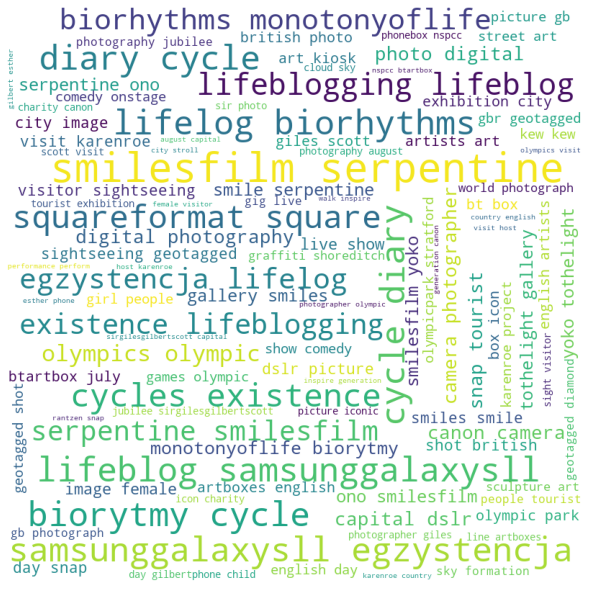

In [ ]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd


comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in tags:
  # split the value
  tokens = val.split()
  
  # Converts each token into lowercase
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
  
  comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [ ]:
tags_count.most_common()

[('olympics', 20423),
 ('serpentine', 11769),
 ('city', 11261),
 ('smilesfilm', 11211),
 ('canon', 9791),
 ('square', 9105),
 ('olympic', 8995),
 ('art', 8576),
 ('geotagged', 7905),
 ('gb', 7714),
 ('thames', 7534),
 ('park', 7447),
 ('squareformat', 7358),
 ('street', 7287),
 ('cycle', 7050),
 ('europe', 6921),
 ('architecture', 6666),
 ('people', 6647),
 ('londres', 6453),
 ('cycles', 6352),
 ('diary', 6248),
 ('existence', 6233),
 ('biorytmy', 6232),
 ('lifeblogging', 6232),
 ('lifeblog', 6232),
 ('samsunggalaxysll', 6232),
 ('egzystencja', 6232),
 ('lifelog', 6232),
 ('biorhythms', 6232),
 ('monotonyoflife', 6232),
 ('gbr', 5706),
 ('british', 5630),
 ('music', 5435),
 ('capital', 5402),
 ('photography', 5350),
 ('live', 5149),
 ('summer', 5034),
 ('english', 5030),
 ('river', 5017),
 ('graffiti', 4950),
 ('photo', 4848),
 ('museum', 4807),
 ('olympicgames', 4796),
 ('greenwich', 4758),
 ('paralympics', 4601),
 ('gig', 4535),
 ('show', 4346),
 ('shoreditch', 4275),
 ('urban', 4242